In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from facenet_pytorch import InceptionResnetV1
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
# 0. Mount Drive if needed (for Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# 1. Device Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
# 2. Hyperparameters
batch_size = 32
epochs = 25
learning_rate = 0.001
img_size = 160  # FaceNet expects 160x160

In [7]:
# 3. Data Preparation
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

data_dir = '/content/drive/MyDrive/Image_Dataset_100' # <-- Path to your dataset

full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# 4. Load FaceNet Feature Extractor
feature_extractor = InceptionResnetV1(pretrained='vggface2', classify=False).to(device)  #facenet model 
feature_extractor.eval()  # Freeze it
for param in feature_extractor.parameters():
    param.requires_grad = False

In [9]:
# 5. Define Custom Classifier
num_classes = len(full_dataset.classes)
class CustomFaceNet(nn.Module):
    def __init__(self, feature_extractor, num_classes):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        with torch.no_grad():
            features = self.feature_extractor(x)
        output = self.classifier(features)
        return output

model = CustomFaceNet(feature_extractor, num_classes).to(device)

In [10]:
# 6. Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)

In [11]:
# 7. Training Loop
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    model.train()
    running_loss, correct = 0.0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / len(train_dataset)

    # Validation
    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = val_correct / len(val_dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

Epoch 1/25 | Train Acc: 0.8893 | Val Acc: 1.0000
Epoch 2/25 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 3/25 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 4/25 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 5/25 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 6/25 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 7/25 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 8/25 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 9/25 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 10/25 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 11/25 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 12/25 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 13/25 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 14/25 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 15/25 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 16/25 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 17/25 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 18/25 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 19/25 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 20/25 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 21/

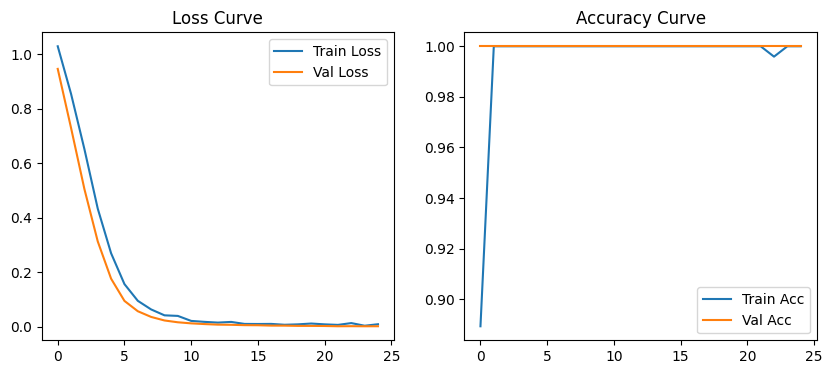

In [12]:
# 8. Plot Training Curve
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

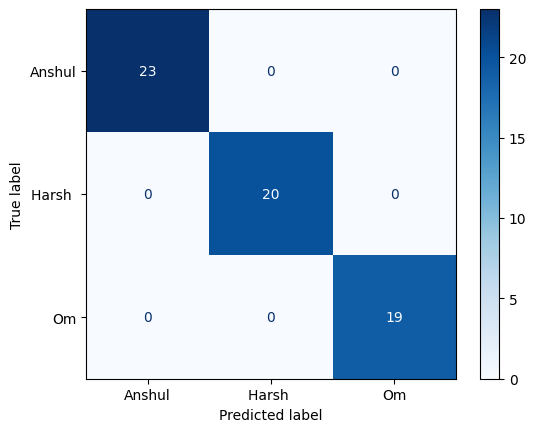

In [13]:
# 9. Confusion Matrix
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [15]:
# 10. Save Model
torch.save(model.state_dict(), 'facenet_custom_model.pth')
print("Custom FaceNet model saved as facenet_custom_model.pth")

Custom FaceNet model saved as facenet_custom_model.pth
